# Benchmark for the Single-Cell drugs data.

Here we present construction of EOT benchmark pairs $\widehat{\mathbb{P}}_0$ and $\widehat{\mathbb{P}}_1$ for the single-cell data used for evaluation OT algorithms in the paper [1]. 

[1] Bunne, C., et al. "Learning Single-Cell Perturbation Responses using Neural Optimal Transport." (2021).

In [1]:
from eot_benchmark.gaussian_mixture_benchmark import ConditionalPlan

# from bio_metrics import compute_scalar_mmd
from bio_data_auxiliary import compute_scalar_mmd, AttrDict, load_cell_data
import pandas as pd

import yaml
import numpy as np

import torch

from sklearn.cluster import KMeans
from sklearn.datasets import make_swiss_roll
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Data loading

In [2]:
config = AttrDict({
    "data": AttrDict({"condition": "drug", "type": "cell",
                      "path": "4i/8h.h5ad",
                      "source": "control", "target": "erlotinib"}),
    "datasplit": AttrDict({"groupby": "drug", "name": "train_test", "test_size": 0.2}),
    "model": AttrDict({"name": "cellot",}),
    "dataloader": AttrDict({"batch_size": 256, "shuffle": True}),
})

Y_train = load_cell_data(config)["train"]["target"].dataset[:]
X_train = load_cell_data(config)["train"]["source"].dataset[:]

### Hyperparameters

In [3]:
N_CLUSTERS = 250
SIGMA = 0.05 # \lambda = EPS / SIGMA due to different parametrization in code
EPS = 1

### Benchmark construction

In [4]:
DIM = 78
k_means = KMeans(n_clusters=N_CLUSTERS)
k_means.fit(Y_train)
potential_probs = torch.ones(N_CLUSTERS)/N_CLUSTERS
potential_mus = torch.tensor(k_means.cluster_centers_)
potential_sigmas = torch.diag(torch.tensor([SIGMA]*DIM))[None, :].repeat(N_CLUSTERS, 1, 1)

conditional_plan = ConditionalPlan(potential_probs, potential_mus, potential_sigmas, eps=EPS, device="cpu")

### TSNE visualization 

In [5]:
plan_train_samples = conditional_plan.sample(torch.tensor(X_train)).detach().cpu().numpy()

pca = PCA(n_components=2)
pca.fit(Y_train)
y_train_pca = pca.transform(Y_train)
plan_train_pca = pca.transform(plan_train_samples)

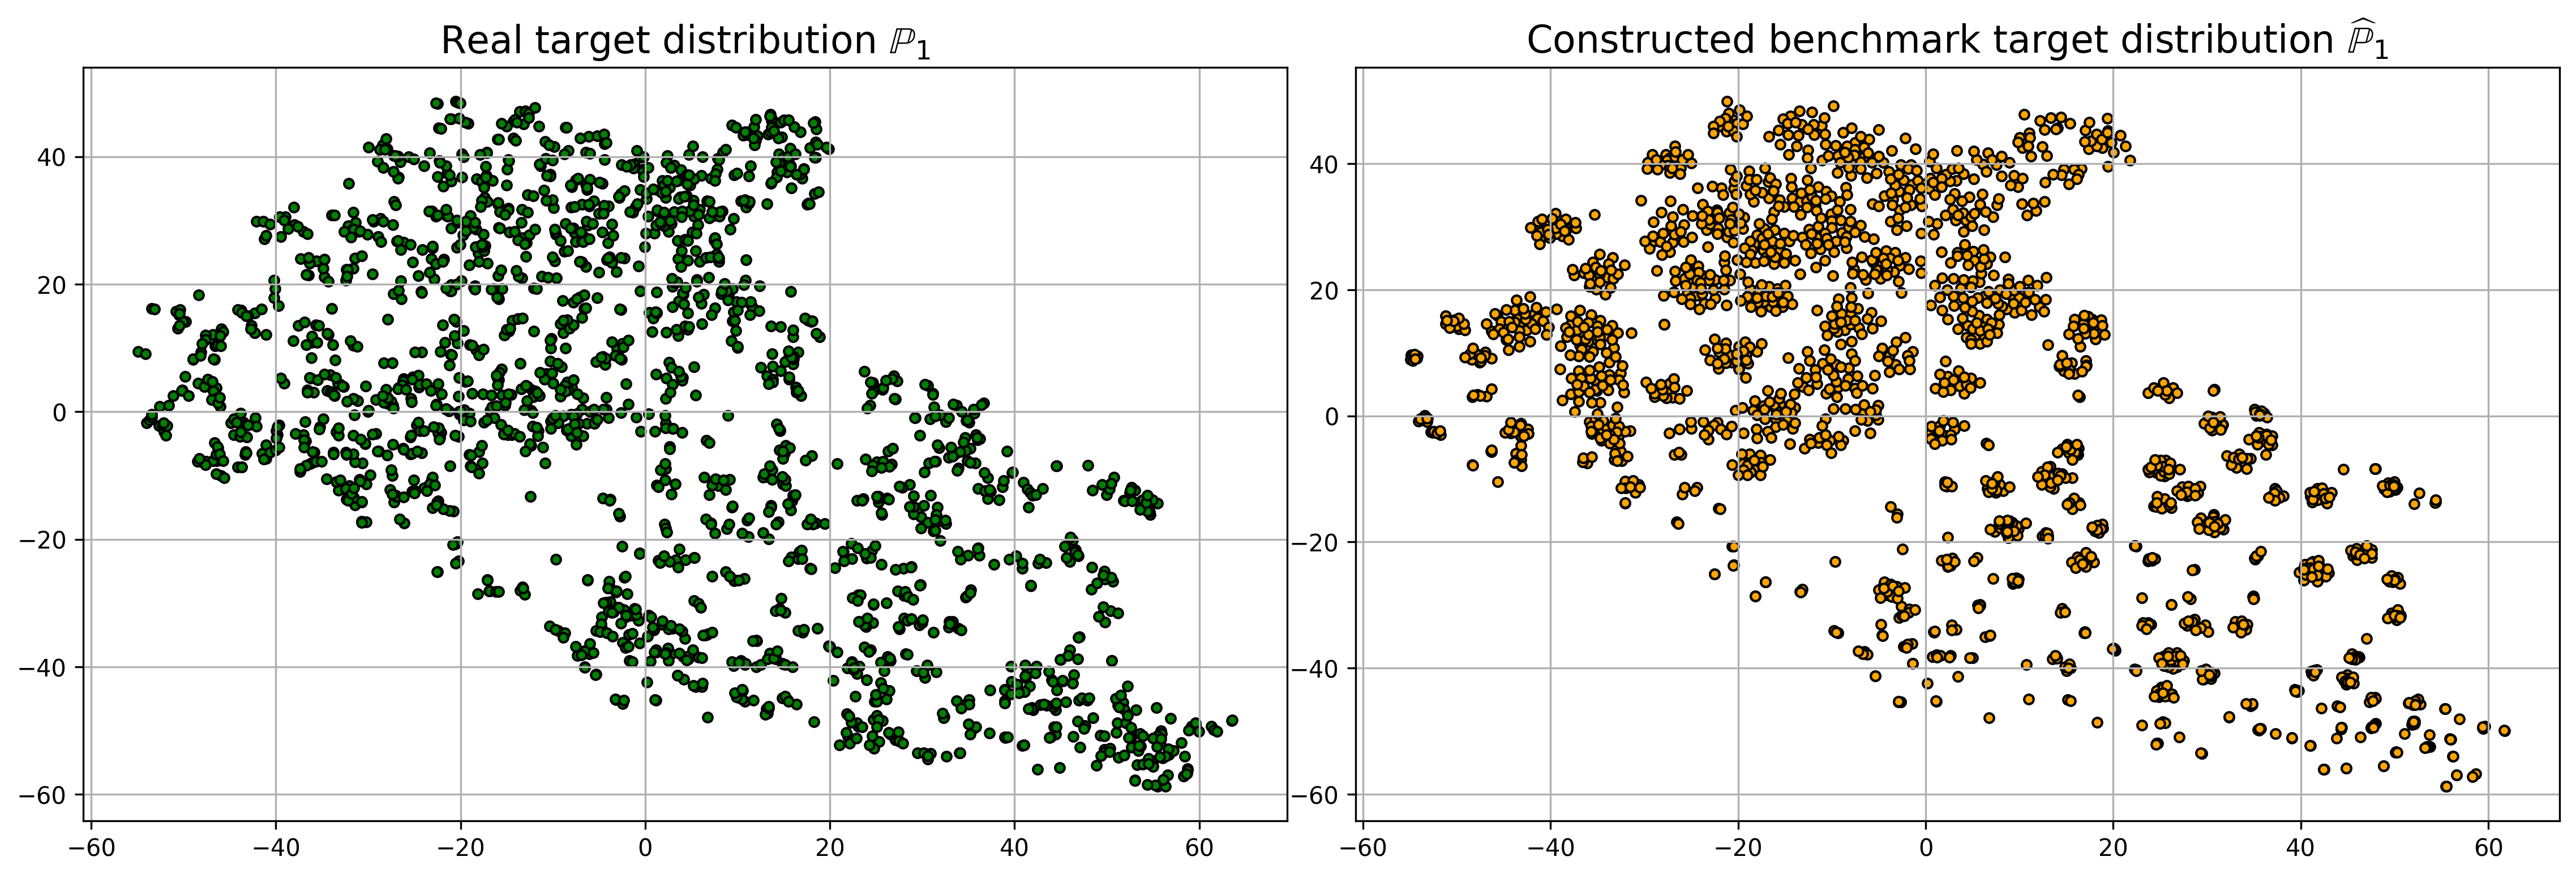

In [6]:
tsne = TSNE()

np.random.shuffle(plan_train_samples)
plan_train_samples = plan_train_samples[:Y_train.shape[0]] # subsample to have the same size for better comparison
Y_train_subsample = Y_train

labels = np.array([0]*Y_train_subsample.shape[0] + [1]*plan_train_samples.shape[0])
tsne_values = tsne.fit_transform(np.concatenate((Y_train_subsample, plan_train_samples), axis=0))

x_min, x_max = tsne_values[:, 0].min(), tsne_values[:, 0].max()
y_min, y_max = tsne_values[:, 1].min(), tsne_values[:, 1].max()

fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

axes[0].scatter(tsne_values[labels==0, 0], tsne_values[labels==0, 1], c="g", s=16, edgecolors="black")
axes[0].grid()
axes[0].set_title(r"Real target distribution $\mathbb{P}_1$", fontsize=16)

axes[1].scatter(tsne_values[labels==1, 0], tsne_values[labels==1, 1], c="orange", s=16, edgecolors="black")
axes[1].grid()
axes[1].set_title(r"Constructed benchmark target distribution $\widehat{\mathbb{P}}_1$", fontsize=16)

fig.tight_layout(pad=0.1)
plt.savefig("TSNE_drugs.png")
plt.show()

### Mapping the test dataset using the constructed Benhcmark map

In [7]:
Y_test = load_cell_data(config)["test"]["target"].dataset[:]
X_test = load_cell_data(config)["test"]["source"].dataset[:]

In [8]:
plan_samples_test = conditional_plan.sample(torch.tensor(X_test)).detach().cpu().numpy()

### Evaluation the quality of estimated target distribution

In [9]:
compute_scalar_mmd(Y_test[:], plan_samples_test[:])

0.003642132579140404

We took reference metrics from [1, Table 1] and add the metric of the constructed benchmark.

Performance assessment of CellOT compared to different baselines and our Benchmark MMD distances between the observed perturbed cells and predicted responses from control cells:

| Method  |  scGen |  cAE | CellOT  | EOT Benchmark (ours)  |
|---|---|---|---|---|
| MMD  | 0.0241  | 0.0074  |  0.0013 |  0.0036 |

Constructed benchmark (ours) better than two baselines in sense of modelling the target distribution on the test set:

[1] Bunne, C., et al. "Learning Single-Cell Perturbation Responses using Neural Optimal Transport." (2021).